# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 24 марта 18:00 Сдача **очная** на занятии. <br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

$w_{new} = w_{old} - \alpha \frac{1}{n}\left[\sum_j (\langle\,x,w_{old}\rangle - y_j)x_{j}\right] + \frac{1}{C}w_{old}$

Интуитивно, возможно, разница между y и скалярном произведении напоминает ошибку, то есть чем мы дальне от точки тем он больше.

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

$w_{new} = w_{old} - \alpha (\frac{1}{n}\sum_{i=1}^n\left(\sigma\left(\langle\,x,w_{old}\rangle\right)-y^{(i)}\right)\,x^{(i)} + \frac{1}{C}w_{old})$



Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

1.
Гессиан - $\frac{\partial A_w}{\partial w_i \partial w_j}$

первые производные равны соответственно
$\nabla_w Q = 2X^TXw-2X^Ty$
то есть гессиан - $2X^TX$ , то есть является положительно определенной квадратичной формой

2.
$Q(w) = \frac{1}{N}(Xw-y)^T(Xw-y)+\frac{1}{C}\sum w^2_i$

учитывая формулу из лекции для градиента (без регуляризации):
$\nabla Q_w = [2X^TXw-2X^Ty]+\frac{2}{C}Ew = 0$


Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

Подставив  $p(y_i = 0 | x_i) = 1 - p(y_i = 1 | x_i)$ и возьмем производную от E по a :

$\frac{1- p(y_i = 1 | x_i)}{1-a} - \frac{p(y_i = 1 | x_i)}{a}$ 

Вторая производная:
$\frac{1 - p(y_i = 1 | x_i)}{(1-a)^2} + \frac{p(y_i = 1 | x_i)}{a^2} > 0$, а первая производная обращается в 0 при $a= p(y_i = 1 | x_i)$



Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

Входные данные не влияют на вклад в решение, который вносит свободный член(потому что не умножаются на него). Нам не нужно чтобы решение сильно реагировало на маленькие изменения каких то фич, для этого и используем регуляризацию, а вклад от свободного члена не меняется при изменении фич. Поэтому штрафовать его смысла нет

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [6]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    inxes = np.array(range(X.shape[0]))
    if shuffle: 
        np.random.shuffle(inxes)
    
    for i in range(X.shape[0]//batch_size):
        X_batch = X[inxes[i*batch_size:(i+1)*batch_size]]
        y_batch = y[inxes[i*batch_size:(i+1)*batch_size]]
        yield (X_batch, y_batch) 
# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [7]:
#%%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    
    ## Your code Here
    return 1 / (1 + np.exp(-x))


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg',batch_size=1, loss_steps=100):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        self.batch_size = batch_size
        self.loss_steps = loss_steps
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
           
        if self.model_type == 'lin_reg':
            return ((np.dot(X_batch, self.weights) - y_batch)**2).mean()
        else:
            sig = sigmoid(X_batch.dot(self.weights)) 
            return -1/X_batch.shape[0] * np.sum(np.log(sig) * y_batch + (1-y_batch) * np.log(1-sig))
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        if self.model_type == 'lin_reg':
            loss_grad = self.alpha/float(X_batch.shape[0]) * (np.sum((X_batch.dot(self.weights) - y_batch).reshape(-1,1)*X_batch,axis=0) + 1./self.C * self.weights)
        else:
            loss_grad = self.alpha/float(X_batch.shape[0]) * (np.sum((sigmoid(X_batch.dot(self.weights)) - y_batch).reshape(-1,1)*X_batch,axis=0) + 1./self.C * self.weights)
            
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights = self.weights - new_grad
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        X = np.hstack([np.ones((X.shape[0],1), float),X])
        # Нужно инициализровать случайно веса
        self.weights = np.random.rand(X.shape[1])  
        tmp_error = []
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X,y, batch_size=self.batch_size, shuffle=True)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                tmp_error.append(self.calc_loss(X_batch, y_batch))
                self.update_weights(batch_grad)
                self.errors_log['iter'].append(batch_num)
                if len(tmp_error) > self.loss_steps:
                    self.errors_log['loss'].append(sum(tmp_error)/len(tmp_error))
                    tmp_error.pop(0)
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        X = np.hstack((np.ones(X.shape[0])[:, np.newaxis],X))
        if  self.model_type == 'lin_reg':
            y_hat = np.dot(X, self.weights)    
        else :
            y_hat = sigmoid(np.dot(X, self.weights))
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [8]:
def plot_decision_boundary(clf, model='lin_reg'):
    clf.fit(X, y)
    w = clf.weights
    th = 0
    if model=='lin_reg':
        th = 0.5
    x_axis = np.linspace(-4., 8.)
    y_line = -(w[0] + (w[1] * x_axis) -th) / w[2]
    plt.plot(x_axis, y_line)

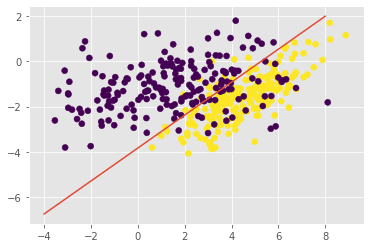

In [9]:
C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]
model_type='lin_reg'
clf = MySGDClassifier(batch_generator=batch_generator,
                          C=1000, max_epoch=100,batch_size=10, alpha=0.01,model_type=model_type)
plot_decision_boundary(clf,model=model_type)


plt.scatter(X[:,0], X[:,1], c=y)

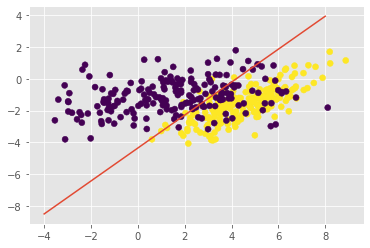

In [10]:
model_type='log_reg'
clf = MySGDClassifier(batch_generator=batch_generator,
                          C=1000, max_epoch=100,batch_size=10, alpha=0.01,model_type=model_type)
plot_decision_boundary(clf,model=model_type)


plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.
        ip.random.seed(0)

In [11]:
from sklearn.datasets import make_classification

In [12]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

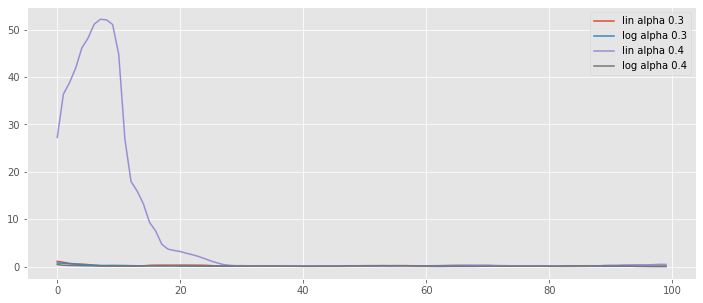

In [1447]:
for alpha in [0.3,0.4]:
    model_type='lin_reg'
    clf = MySGDClassifier(batch_generator=batch_generator,
                C=1000, max_epoch=10, alpha=alpha,model_type=model_type, 
                batch_size=10, loss_steps=10)
    clf.fit(X,y)
    plt.plot(clf.errors_log['loss'][0:100],label='lin alpha {}'.format(alpha))
    model_type='log_reg'
    clf = MySGDClassifier(batch_generator=batch_generator,
                C=1000, max_epoch=10, alpha=alpha,model_type=model_type, 
                batch_size=10, loss_steps=10)
    clf.fit(X,y)
    plt.plot(clf.errors_log['loss'][0:100],label='log alpha {}'.format(alpha))
plt.legend()

###Видно что 0.4 - много, не сходится.

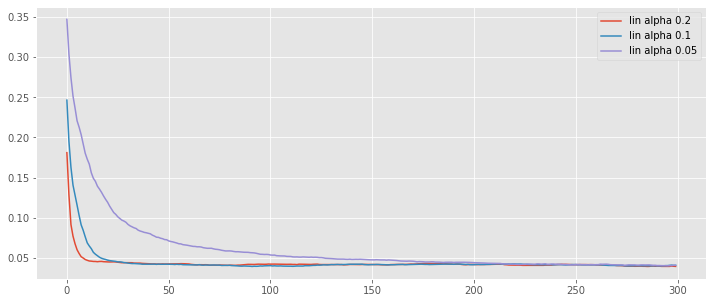

In [1448]:
for alpha in [0.2,0.1,0.05]:
    model_type='lin_reg'
    clf = MySGDClassifier(batch_generator=batch_generator,
                C=1000, max_epoch=10, alpha=alpha,model_type=model_type, 
                batch_size=50, loss_steps=100)
    clf.fit(X,y)
    plt.plot(clf.errors_log['loss'][0:300],label='lin alpha {}'.format(alpha))
plt.legend()

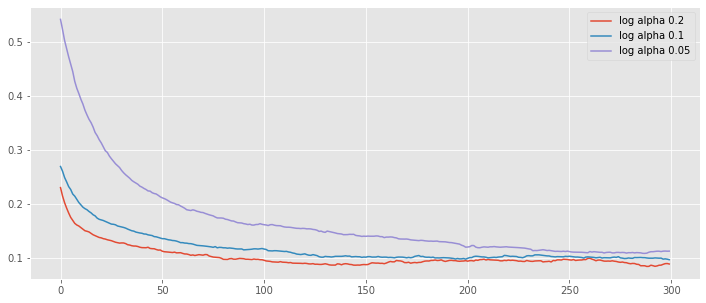

In [1449]:
for alpha in [0.2,0.1,0.05]:
    model_type='log_reg'
    clf = MySGDClassifier(batch_generator=batch_generator,
                C=1000, max_epoch=10, alpha=alpha,model_type=model_type, 
                batch_size=50, loss_steps=100)
    clf.fit(X,y)
    plt.plot(clf.errors_log['loss'][:300],label='log alpha {}'.format(alpha))
plt.legend()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Чем больше альфа тем быстрее сходится, но если взять слишком большое , ошибка начинает прыгать

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

In [1108]:
## Your Code Here
lin_weights = []
log_weights = []
for C in np.logspace(3,-3,10):
    clf =MySGDClassifier(batch_generator=batch_generator,
                              C=C, max_epoch=10, alpha=0.05,model_type='lin_reg', batch_size=50)
    clf.fit(X, y) 
    lin_weights.append(np.abs(clf.weights).mean())
    clf =MySGDClassifier(batch_generator=batch_generator,
                              C=C, max_epoch=10, alpha=0.05,model_type='log_reg', batch_size=50)
    clf.fit(X, y) 
    log_weights.append(np.abs(clf.weights).mean())



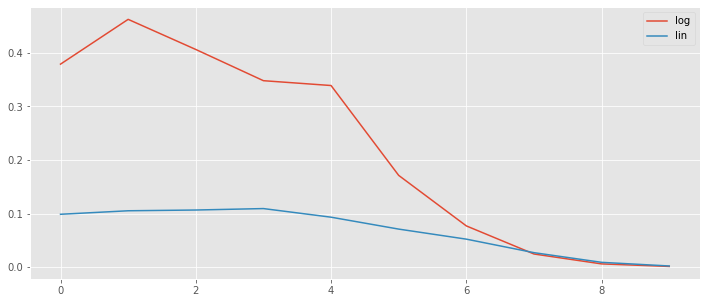

In [1109]:
plt.plot(weights_log, label='log')
plt.plot(weights_lin, label='lin')
plt.legend()

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

Существенно уменьшились, я доволен!

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [13]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [14]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [15]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [16]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)


In [17]:
X_train.shape

(11690, 15)

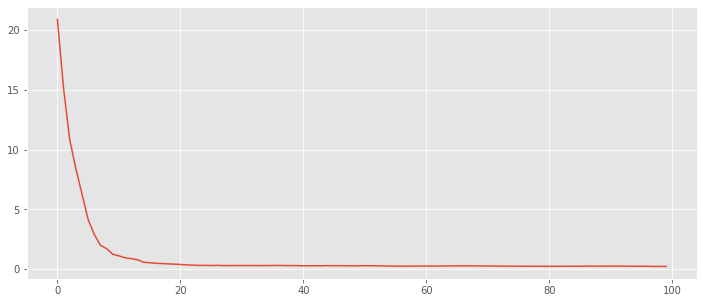

In [1462]:
clf = MySGDClassifier(batch_generator,  C = 1, alpha=0.01, max_epoch = 5, model_type='lin_reg', batch_size = 80,loss_steps=10)
clf.fit(X_train, y_train)
clf.predict(X_train)

plt.plot(clf.errors_log['loss'][0:100])

In [1458]:
len(clf.errors_log['loss'])

720

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

Разбиваем так чтобы одна и таже группа не попала одновременно в train и test

In [19]:
#[(),(),()]
splitting = []
test_ind = groups_train<=43
splitting.append((~test_ind,test_ind))
test_ind = (groups_train>43) & (groups_train <=86)
splitting.append((~test_ind,test_ind))
test_ind = groups_train>86
splitting.append((~test_ind,test_ind))


In [20]:
def loss(pred, y_true):
    return ((pred - y_true)**2).mean()

lin_g_scores = []
for alpha in np.arange(0.01,0.1,0.01):
    for C in np.logspace(3, -3, 10):
        for max_epoch in range(1,10):
            tmp_lin_g_scores = []
            for train, test in splitting:
                clf = MySGDClassifier(batch_generator, alpha=alpha, max_epoch=max_epoch, model_type='lin_reg', batch_size = 80, C=C)
                clf.fit(X_train[train], y_train[train])
                pred = clf.predict(X_train[test])
                tmp_lin_g_scores.append(loss(pred, y_train[test]))
            lin_g_scores.append({'C': C, 'alpha':alpha, 'max_epoch' : max_epoch, 'score' : sum(tmp_lin_g_scores)})
        
    

In [21]:
lin_g_scores.sort(key=lambda x: x['score'])
lin_g_scores[0]

{'C': 0.4641588833612782,
 'alpha': 0.08,
 'max_epoch': 9,
 'score': 0.4713905635989487}

In [22]:
lin_best = lin_g_scores[0]
lin_best

{'C': 0.4641588833612782,
 'alpha': 0.08,
 'max_epoch': 9,
 'score': 0.4713905635989487}

In [23]:
def loss(pred, y_true):
    return -(y_true * np.log(pred) + (1- y_true)*np.log(1-pred)).mean()
log_g_scores = []
for alpha in np.arange(0.01,0.2,0.01):
    for C in np.logspace(3, -3, 10):
        for max_epoch in range(1,10):
            tmp_log_g_scores = []
            for train, test in splitting:
                clf = MySGDClassifier(batch_generator, alpha=alpha, max_epoch=max_epoch, model_type='log_reg', batch_size = 80, C=C)
                clf.fit(X_train[train], y_train[train])
                pred = clf.predict(X_train[test])
                tmp_log_g_scores.append(loss(pred, y_train[test]))
            log_g_scores.append({'C': C, 'alpha':alpha, 'max_epoch' : max_epoch, 'score' : sum(tmp_log_g_scores)})
log_g_scores.sort(key=lambda x: x['score'])
log_g_scores[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


{'C': 10.0, 'alpha': 0.05, 'max_epoch': 9, 'score': 1.443542758693259}

In [27]:
log_best = log_g_scores[0]
log_best

{'C': 10.0, 'alpha': 0.05, 'max_epoch': 9, 'score': 1.443542758693259}

Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

Будем подбирать порог и измерять f1. Такой узкий range порога изза того что я проделал операцию несколько раз

In [36]:
from sklearn.metrics import f1_score
log_f1_scores = []
for th in np.arange(0.458, 0.462, 0.0001):
    tmp_log_f1_scores = []
    for train, test in splitting:
        clf = MySGDClassifier(batch_generator, alpha=log_best['alpha'], max_epoch=log_best['max_epoch'], model_type='log_reg', batch_size = 80, C = log_best['C'])
        clf.fit(X_train[train], y_train[train])
        pred = clf.predict(X_train[test])                
        new_pred = np.where(pred < th, 0, 1)
        tmp_log_f1_scores.append(f1_score(new_pred,y_train[test]))
    log_f1_scores.append({'th':th, 'f1':sum(tmp_log_f1_scores)/len(tmp_log_f1_scores)})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply


In [60]:
log_f1_scores.sort(key=lambda x: x['f1'],reverse=True)
log_best['th'] = log_f1_scores[0]['th']
log_best

{'C': 10.0,
 'alpha': 0.05,
 'max_epoch': 9,
 'score': 1.443542758693259,
 'th': 0.45879999999999993}

In [51]:
from sklearn.metrics import f1_score
lin_f1_scores = []
for th in np.arange(0.45, 0.463, 0.0001):
    tmp_lin_f1_scores = []
    for train, test in splitting:
        clf = MySGDClassifier(batch_generator, alpha=lin_best['alpha'], max_epoch=lin_best['max_epoch'], model_type='lin_reg', batch_size = 80, C = lin_best['C'])
        clf.fit(X_train[train], y_train[train])
        pred = clf.predict(X_train[test])                
        new_pred = np.where(pred < th, 0, 1)
        tmp_lin_f1_scores.append(f1_score(new_pred,y_train[test]))
    lin_f1_scores.append({'th':th, 'f1':sum(tmp_lin_f1_scores)/len(tmp_lin_f1_scores)})

In [59]:
lin_f1_scores.sort(key=lambda x: x['f1'],reverse=True)
lin_best['th']=lin_f1_scores[0]['th']
lin_best

{'C': 0.4641588833612782,
 'alpha': 0.08,
 'max_epoch': 9,
 'score': 0.4713905635989487,
 'th': 0.45339999999999964}

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

In [ ]:
#Сабмит

In [38]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [39]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    pair_id =  new_doc['pair_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title, pair_id))

In [40]:
import numpy as np
X_test = []
pair_ids = []
groups_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title, pair_id) in enumerate(docs):
        pair_ids.append(pair_id)
        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, pair_id_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15])
pair_ids = np.array(pair_ids)
X_test = np.array(X_test)
groups_test = np.array(groups_test)
print (X_test.shape, groups_test.shape, pair_ids.shape)

(16627, 15) (16627,) (16627,)


In [41]:
X_test = sc.transform(X_test)

In [54]:
best = log_best

In [55]:
clf = MySGDClassifier(batch_generator, alpha=best['alpha'], max_epoch=best['max_epoch'], model_type='log_reg', batch_size = 80, C = best['C'])
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
new_pred = np.where(pred < best['th'], 0, 1)

In [57]:
df = pd.DataFrame({'pair_id': pair_ids, 'target': new_pred})

In [58]:
df.to_csv('sub.csv', index=False)

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

Хотелось бы больше объяснений применимых к практике, интерпритаций этих плоскостей, вероятностей, как они соотносятся с весами в модели, данными которые мы получаем на выходе тд. Когда делал, пришлось приложить усилия, чтобы связать теорию и практику. 

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***